# Quantum image representation based on bitplanes - [BRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.li2018quantum)

Image is assumed a collection of bitbpanes. Each image has 8 separate bitplanes (in a gray-scaled case). Every bitplane is discribed as follows:

$| \Psi_m^j \rangle = \frac{1}{2^n}\sum_{x=0}^{2^{n-k}-1}\sum_{y=0}^{2^k-1} | g(x,y) \rangle |x \rangle | y \rangle$, where

$\Psi_m^j$ - bitplane representation;

$j = (0,... 7)$ - number of bitplane;

$m = 1$ (in gray scaled case) - band number;

$g(x,y) = (0,1)$ - pre-/absence if $j^{th}$ bitplane in the band $m$

Step 0: dependencies import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.extensions import XGate
import math

Step 1: image generation

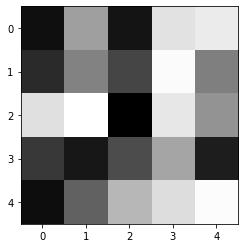

[[ 15 142  19 202 210]
 [ 39 117  63 224 114]
 [200 228   1 206 133]
 [ 52  22  69 148  27]
 [ 13  88 164 197 225]]


In [2]:
image = np.random.uniform(low=0, high=255, size=(5,5)).astype(int)

plt.imshow(image, cmap = 'gray')
plt.show()

Step 2: amount of qubits calculation

In [3]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
color_n_b = 8
color_n_b = int(np.ceil(math.log(color_n_b,2)))

Step 4: BRQI image encoding

In [4]:
color = QuantumRegister(1, 'color')
y_ax = QuantumRegister(w_bits, 'y axis')
x_ax = QuantumRegister(h_bits, 'x axis')
bitplane_q = QuantumRegister(color_n_b, 'bitplanes')
classic = ClassicalRegister(1+w_bits+h_bits+color_n_b, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, bitplane_q, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.h(bitplane_q)

qc.barrier()

for bitplane in range(8):
    bit_bitplane = "{0:b}".format(bitplane).zfill(color_n_b)
    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = "{0:b}".format(image[i,j]).zfill(8)
            if pixel[bitplane]=='1':
                i_bit = "{0:b}".format(i).zfill(h_bits)
                for i_n, ibit in enumerate(i_bit):
                    if ibit!='1':
                        qc.x(x_ax[i_n])
                    j_bit = "{0:b}".format(j).zfill(w_bits)
                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])
                qc.barrier()

                controls = list(range(color.size,
                                      qc.num_qubits))
                xg = XGate(None).control(len(controls))
                controls.append(color)
                qc.append(xg, controls)

                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])

                for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            qc.x(x_ax[i_n])
                qc.barrier()

    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
qc.barrier()
qc.measure(list(reversed(range(qc.num_qubits))), list(range(classic.size)))

Quantum scheme visualization

In [7]:
qc.draw()

<pre style="word-wrap: normal;white-space: pre;background: #fff0;line-height: 1.1;font-family: &quot;Courier New&quot;,Courier,monospace">             ┌───┐ ░       ░ ┌───┐      ░       ░ ┌───┐      ░       ░ ┌───┐»
    color_0: ┤ I ├─░───────░─┤ X ├──────░───────░─┤ X ├──────░───────░─┤ X ├»
             ├───┤ ░ ┌───┐ ░ └─┬─┘┌───┐ ░ ┌───┐ ░ └─┬─┘┌───┐ ░       ░ └─┬─┘»
   y axis_0: ┤ H ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░───────░───■──»
             ├───┤ ░ ├───┤ ░   │  ├───┤ ░ └───┘ ░   │  └───┘ ░ ┌───┐ ░   │  »
   y axis_1: ┤ H ├─░─┤ X ├─░───■──┤ X ├─░───────░───■────────░─┤ X ├─░───■──»
             ├───┤ ░ └───┘ ░   │  └───┘ ░       ░   │        ░ ├───┤ ░   │  »
   y axis_2: ┤ H ├─░───────░───■────────░───────░───■────────░─┤ X ├─░───■──»
             ├───┤ ░ ┌───┐ ░   │  ┌───┐ ░ ┌───┐ ░   │  ┌───┐ ░ ├───┤ ░   │  »
   x axis_0: ┤ H ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
             ├───┤ ░ ├───┤ ░   │  ├───┤ ░ ├───┤ ░   │  ├───┤ ░ ├───┤ ░   │  »
   x axis_1: ┤ H ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
             ├───┤ ░ ├───┤ ░   │  ├───┤ ░ ├───┤ ░   │  ├───┤ ░ ├───┤ ░   │  »
   x axis_2: ┤ H ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
             ├───┤ ░ ├───┤ ░   │  └───┘ ░ └───┘ ░   │  └───┘ ░ └───┘ ░   │  »
bitplanes_0: ┤ H ├─░─┤ X ├─░───■────────░───────░───■────────░───────░───■──»
             ├───┤ ░ ├───┤ ░   │        ░       ░   │        ░       ░   │  »
bitplanes_1: ┤ H ├─░─┤ X ├─░───■────────░───────░───■────────░───────░───■──»
             ├───┤ ░ ├───┤ ░   │        ░       ░   │        ░       ░   │  »
bitplanes_2: ┤ H ├─░─┤ X ├─░───■────────░───────░───■────────░───────░───■──»
             └───┘ ░ └───┘ ░            ░       ░            ░       ░      »
 classic: 10/═══════════════════════════════════════════════════════════════»
                                                                            »
«                   ░       ░ ┌───┐      ░       ░ ┌───┐      ░       ░ ┌───┐»
«    color_0: ──────░───────░─┤ X ├──────░───────░─┤ X ├──────░───────░─┤ X ├»
«                   ░ ┌───┐ ░ └─┬─┘┌───┐ ░ ┌───┐ ░ └─┬─┘┌───┐ ░ ┌───┐ ░ └─┬─┘»
«   y axis_0: ──────░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
«             ┌───┐ ░ └───┘ ░   │  └───┘ ░ ├───┤ ░   │  ├───┤ ░ ├───┤ ░   │  »
«   y axis_1: ┤ X ├─░───────░───■────────░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
«             ├───┤ ░       ░   │        ░ ├───┤ ░   │  ├───┤ ░ └───┘ ░   │  »
«   y axis_2: ┤ X ├─░───────░───■────────░─┤ X ├─░───■──┤ X ├─░───────░───■──»
«             ├───┤ ░ ┌───┐ ░   │  ┌───┐ ░ ├───┤ ░   │  ├───┤ ░ ┌───┐ ░   │  »
«   x axis_0: ┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
«             ├───┤ ░ ├───┤ ░   │  ├───┤ ░ └───┘ ░   │  └───┘ ░ └───┘ ░   │  »
«   x axis_1: ┤ X ├─░─┤ X ├─░───■──┤ X ├─░───────░───■────────░───────░───■──»
«             ├───┤ ░ └───┘ ░   │  └───┘ ░ ┌───┐ ░   │  ┌───┐ ░ ┌───┐ ░   │  »
«   x axis_2: ┤ X ├─░───────░───■────────░─┤ X ├─░───■──┤ X ├─░─┤ X ├─░───■──»
«             └───┘ ░       ░   │        ░ └───┘ ░   │  └───┘ ░ └───┘ ░   │  »
«bitplanes_0: ──────░───────░───■────────░───────░───■────────░───────░───■──»
«                   ░       ░   │        ░       ░   │        ░       ░   │  »
«bitplanes_1: ──────░───────░───■────────░───────░───■────────░───────░───■──»
«                   ░       ░   │        ░       ░   │        ░       ░   │  »
«bitplanes_2: ──────░───────░───■────────░───────░───■────────░───────░───■──»
«                   ░       ░            ░       ░            ░       ░      »
« classic: 10/═══════════════════════════════════════════════════════════════»
«                                                                            »
«                   ░       ░ ┌───┐      ░       ░ ┌───┐      ░       ░ ┌───┐»
«    color_0: ──────░───────░─┤ X ├──────░───────░─┤ X ├──────░───────░─┤ X ├»
«             ┌───┐ ░ ┌───┐ ░ └─┬─┘┌───┐ ░       ░ └─┬─┘      ░ ┌───┐ ░ └─┬─┘»
«   y axis_0: 

Step 5: circuit execution

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=1000000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

Step 6: results interpretation. Images and similarity of digital representation show that image was encoded and measured correct.

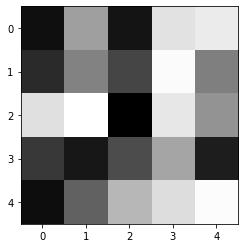

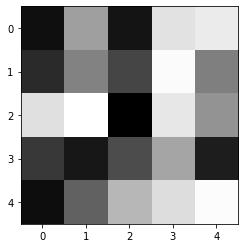

[[ 15 142  19 202 210]
 [ 39 117  63 224 114]
 [200 228   1 206 133]
 [ 52  22  69 148  27]
 [ 13  88 164 197 225]]
[[ 15 142  19 202 210]
 [ 39 117  63 224 114]
 [200 228   1 206 133]
 [ 52  22  69 148  27]
 [ 13  88 164 197 225]]


In [9]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:color.size], 2),
                       int(item[color.size:color.size+x_ax.size],2),
                       int(item[color.size+x_ax.size:color.size+x_ax.size+y_ax.size],2),
                       int(item[color.size+x_ax.size+y_ax.size:qc.num_qubits],2)
                     ))
out_image = []
for k in range(image.shape[0]):
    for j in range(image.shape[1]):
        bits = [i for i in range(len(out_pixels)) if out_pixels[i][1] == k and out_pixels[i][2] == j]
        pixel = np.zeros((8,))
        for bit in bits:
            pixel[out_pixels[bit][3]] = int(out_pixels[bit][0])
        mystring = "".join([str(int(a)) for a in pixel])
        out_image.append(int(mystring, 2))
out_image = np.array(out_image).reshape(image.shape[1], image.shape[0])
plt.imshow(out_image.T, cmap = 'gray')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.show()

print(out_image.T)
print(image)